In [1]:
import torch
from torch import nn
import os
from pathlib import Path
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
device

'cuda'

In [3]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:

# Setup path to data folder
data_path = Path("data/")

walk_through_dir(data_path)


There are 11 directories and 0 images in 'data'.
There are 0 directories and 38 images in 'data\A&B50'.
There are 0 directories and 31 images in 'data\A&C&B10'.
There are 0 directories and 42 images in 'data\A&C&B30'.
There are 0 directories and 31 images in 'data\A&C10'.
There are 0 directories and 38 images in 'data\A&C30'.
There are 0 directories and 34 images in 'data\A10'.
There are 0 directories and 37 images in 'data\A30'.
There are 0 directories and 35 images in 'data\A50'.
There are 0 directories and 28 images in 'data\Fan'.
There are 0 directories and 25 images in 'data\Noload'.
There are 0 directories and 30 images in 'data\Rotor-0'.


In [5]:
# Setup path for target directory
target_directory = data_path 
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(data_path ))])
print(f"Class names found: {class_names_found}")

Target directory: data
Class names found: ['A&B50', 'A&C&B10', 'A&C&B30', 'A&C10', 'A&C30', 'A10', 'A30', 'A50', 'Fan', 'Noload', 'Rotor-0']


In [6]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
  
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [7]:
find_classes(data_path)

(['A&B50',
  'A&C&B10',
  'A&C&B30',
  'A&C10',
  'A&C30',
  'A10',
  'A30',
  'A50',
  'Fan',
  'Noload',
  'Rotor-0'],
 {'A&B50': 0,
  'A&C&B10': 1,
  'A&C&B30': 2,
  'A&C10': 3,
  'A&C30': 4,
  'A10': 5,
  'A30': 6,
  'A50': 7,
  'Fan': 8,
  'Noload': 9,
  'Rotor-0': 10})

In [8]:
from torchvision.datasets import VisionDataset

class ThermicMotorsImagesDataset(VisionDataset):
    def __init__(self, root: str, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        # Get class names and mapping
        self.classes, self.class_to_idx = find_classes(root)

        # Collect image paths and corresponding labels
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(root, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, path: str) -> Image.Image:
        """Loads an image from a given path."""
        return Image.open(path).convert("RGB")

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = self.load_image(img_path)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [9]:
thermic_transformer=transforms.Compose([
    transforms.Resize((128, 128)),  # a bit more detail preserved
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # simulate noise in temp readings
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize to [-1,1] (optional)
])


In [10]:
fsl_dataset = ThermicMotorsImagesDataset(
    root=data_path,
    transform=thermic_transformer
)
len(fsl_dataset), len(fsl_dataset.classes), fsl_dataset.class_to_idx, fsl_dataset[0][0].shape, fsl_dataset[0][1] # (number of images, number of classes, class_to_idx mapping, image shape, label)

(369,
 11,
 {'A&B50': 0,
  'A&C&B10': 1,
  'A&C&B30': 2,
  'A&C10': 3,
  'A&C30': 4,
  'A10': 5,
  'A30': 6,
  'A50': 7,
  'Fan': 8,
  'Noload': 9,
  'Rotor-0': 10},
 torch.Size([3, 128, 128]),
 0)

In [11]:
from torch.utils.data import Sampler
from collections import defaultdict
import random

class EpisodicSampler(Sampler):
    def __init__(self, labels, n_way, k_shot, q_query, num_episodes):
        """
        Few-Shot Episodic Sampler

        Args:
            labels (List[int]): List of all labels in dataset (same order as dataset indices)
            n_way (int): Number of classes per episode
            k_shot (int): Number of support samples per class
            q_query (int): Number of query samples per class
            num_episodes (int): How many episodes per epoch
        """
        self.labels = labels
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.num_episodes = num_episodes

        self.class_to_indices = self._build_class_index()

    def _build_class_index(self):
        class_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            class_to_indices[label].append(idx)
        return class_to_indices

    def __len__(self):
        return self.num_episodes

    def __iter__(self):
        for _ in range(self.num_episodes):
            selected_classes = random.sample(list(self.class_to_indices.keys()), self.n_way)

            episode_indices = []

            for cls in selected_classes:
                indices = random.sample(self.class_to_indices[cls], self.k_shot + self.q_query)
                episode_indices.extend(indices)

            yield episode_indices


In [12]:
sampler = EpisodicSampler(
    labels=fsl_dataset.labels,
    n_way=5,
    k_shot=1,
    q_query=5,
    num_episodes=100
)

loader = torch.utils.data.DataLoader(
    fsl_dataset,
    batch_sampler=sampler,
    num_workers= os.cpu_count() # 
)


In [16]:
import matplotlib.pyplot as plt
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))
    
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # Denormalize the image
        targ_image = targ_image * 0.5 + 0.5
        
        # Adjust tensor shape for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0).numpy()
        
        # Handle grayscale images
        if targ_image_adjust.shape[-1] == 1:
            targ_image_adjust = targ_image_adjust.squeeze(-1)
        
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_image_adjust, cmap='gray' if targ_image_adjust.ndim == 2 else None)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
            plt.title(title)

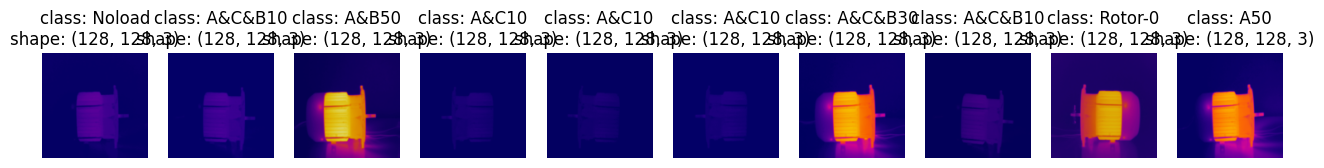

In [17]:
display_random_images(fsl_dataset, classes=fsl_dataset.classes, n=10, display_shape=True, seed=42)
# 